In [49]:
import os, copy, re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from prettytable import PrettyTable
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [186]:
# load the dataset
path = os.getcwd() + "/data/train_data.csv"
music = pd.read_csv(path)

# add in sentiment
sentiment = pd.read_csv('data/sent_data.csv')
music['sentiment'] = sentiment.sentiment

In [29]:
music['release.id'][2]

358182

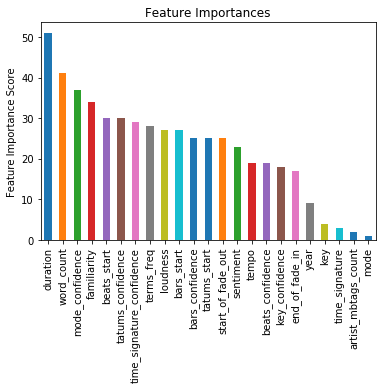

In [188]:
# model graphs
#get rid of tags that have missing values and add target for train test split
target = copy.deepcopy(music.billboard)
train = music.drop(['billboard','lyrics', 'Unnamed: 0','release.id'], axis=1)
 
x_train, x_test, y_train, y_test = train_test_split(train,
                                                    target,
                                                    test_size=.4,
                                                    train_size=.1,
                                                    random_state=0,
                                                    stratify = target)

# fit model
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)
feat_imp = pd.Series(XGB_model.get_booster().get_fscore()).sort_values(ascending=False)

# creating the plot
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.savefig('figures/feature_importances.pdf', bbox_inches='tight')

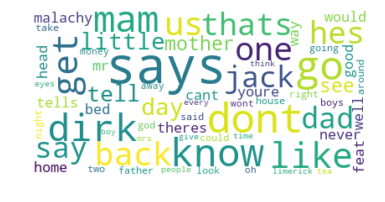

In [72]:
# word clouds

# # get count of all words in corpus from 2010 that are billboard
counts_dict = {}
for lyrics in music[(music['year'] == 2000) & (music['billboard']==1)]['lyrics']:
    words = nltk.word_tokenize(lyrics)
    for word in words:
        word = re.sub(r'[^\w\s]','',word)
        if word not in nltk.corpus.stopwords.words() and not word.isnumeric():
            if word in counts_dict:
                counts_dict[word] = counts_dict[word]+1
            else:
                counts_dict[word] = 1


# only keep very frequent words
top_words = {key:val for key, val in counts_dict.items() if val > 200 and key != ""}

# create table from dictionary        
# table1 = PrettyTable(['Word', 'Count'])
# for word, count in top_words.items():
#    table1.add_row([word, count])

# table1.sortby = "Count"
# table1.reversesort = True
# print(table1)


# generate wordcloud
wordcloud=WordCloud(max_font_size=60,
                    background_color='white',
                    stopwords=['the','to','of','and','is','as','in']
                   ).generate_from_frequencies(top_words)

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig("figures/wordcloud1990.pdf")


In [89]:
# creating sentiment analysis variable
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
sentiment = SentimentIntensityAnalyzer()

sentiments = []
for lyrics in music['lyrics']:    
    score = sentiment.polarity_scores(lyrics)['compound']
    sentiments.append(score)

# add column to database
music['sentiment'] = sentiments

# graph billboard against sentiment
# plot = sns.regplot(data=music,x='sentiment',y='billboard',color='green',marker='+')
# plot.savefig("figures/sentiment.pdf")



In [ ]:
# training with sentiment added in
train = train.drop('lyrics', axis=1)
display(train.head())
x_train, x_test, y_train, y_test = train_test_split(train,
                                                                        target,
                                                                        test_size=.4,
                                                                        train_size=.1,
                                                                        random_state=0,
                                                                        stratify = target)



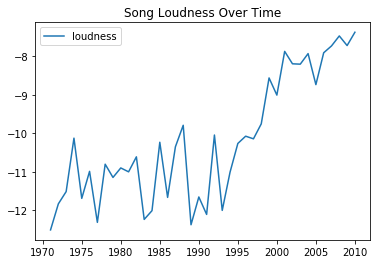

In [198]:
# loudness over time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# loudness over time
var = 'loudness'
plot_df = pd.DataFrame(train.groupby('year', as_index=False)[var].mean())

plot_df.plot('year', var)
plt.xlabel("")
plt.title("Song Loudness Over Time")

plt.savefig('figures/loudness.pdf')


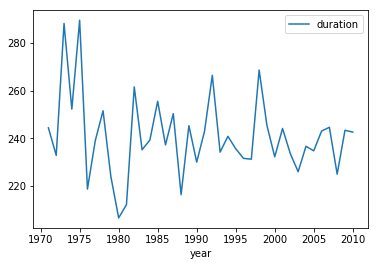

In [71]:
# duration over time
var = 'duration'
plot_df = pd.DataFrame(train.groupby('year', as_index=False)[var].mean())
plot_df.plot('year', var)

plt.savefig('figures/duration.pdf')

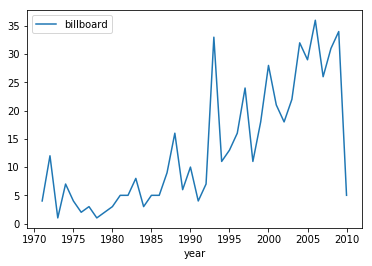

In [87]:
# count of billboard songs across the years
var = 'billboard'
plot_df = pd.DataFrame(music.groupby('year', as_index=False)[var].sum())
plot_df.plot('year', var)

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/yearly_count.pdf
  warn('Filename: {}'.format(filename))


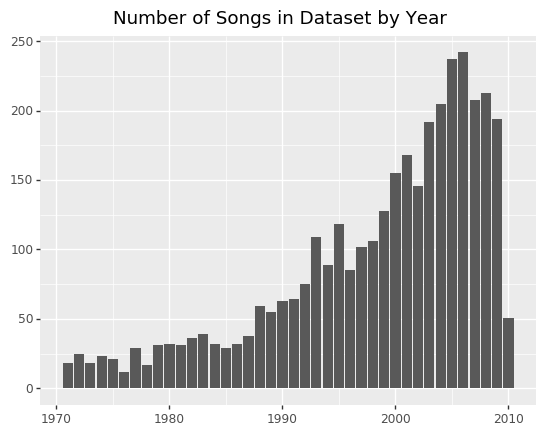

<ggplot: (-9223372036557635675)>

In [90]:
from plotnine import *

p = (ggplot(music)         # defining what data to use
 + aes(x='year')    # defining what variable to use
 + geom_bar(size=20)
 + labs(title="Number of Songs in Dataset by Year", x="",y="")
)
ggsave(p,"figures/yearly_count.pdf")
p

In [86]:
plot_df.head(5)

,year,billboard
0,1971,4
1,1972,12
2,1973,1
3,1974,7
4,1975,4


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/hit_duration.pdf
  warn('Filename: {}'.format(filename))


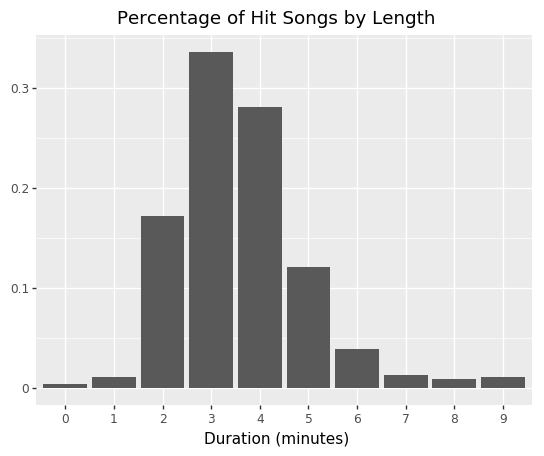

<ggplot: (-9223372036557611702)>

In [173]:
# song duration
from plotnine import *
import numpy as np

hits = music[music.billboard==1]
hits['duration_group'] = pd.cut(hits.duration,
                     bins=np.arange(0,660,60),
                     labels=np.arange(0,10,1))

plot_df = pd.DataFrame(hits.groupby('duration_group', as_index=False)['year'].count())
plot_df.year = plot_df.year.div(530)

p = (ggplot(plot_df)         # defining what data to use
 + aes(x='duration_group',
      y = 'year')    # defining what variable to use
 + geom_bar(stat='identity',
            size=2)
 + labs(title="Percentage of Hit Songs by Length", x="Duration (minutes)",y="")
)

ggsave(p,"figures/hit_duration.pdf")
p

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/dud_duration.pdf
  warn('Filename: {}'.format(filename))


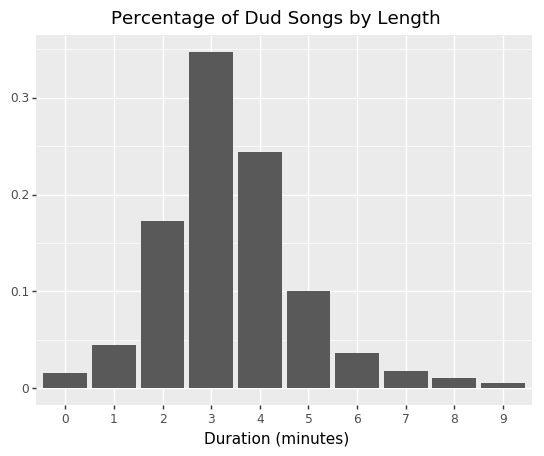

<ggplot: (-9223372036553421617)>

In [174]:
# song duration
from plotnine import *
import numpy as np

duds = music[music.billboard==0]
duds['duration_group'] = pd.cut(duds.duration,
                     bins=np.arange(0,660,60),
                     labels=np.arange(0,10,1))

plot_df = pd.DataFrame(duds.groupby('duration_group', as_index=False)['year'].count())
plot_df.year = plot_df.year.div(2997)


p = (ggplot(plot_df)         # defining what data to use
 + aes(x='duration_group',
      y = 'year')    # defining what variable to use
 + geom_bar(stat='identity',
            size=2)
 + labs(title="Percentage of Dud Songs by Length", x="Duration (minutes)",y="")
)

ggsave(p,"figures/dud_duration.pdf")
p

In [185]:
# average amount of time
hits_avg = hits.duration.mean()
duds_avg = duds.duration.mean()

# duration of duds is shorter 
print(hits_avg,duds_avg)

247.5671709433963 237.24567643977315


Average sentiment of hit song lyrics: 0.31
Average sentiment of non-hit song lyrics: 0.19


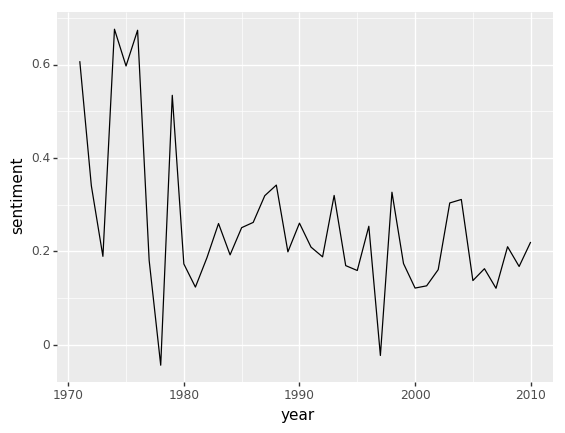

<ggplot: (-9223372036553421694)>

In [181]:
# sentiment vizualation
sentiment = pd.read_csv('data/sent_data.csv')
music['sentiment'] = sentiment.sentiment

# sentiment in hits vs non-hits
hits_avg = hits.sentiment.mean()
duds_avg = duds.sentiment.mean()

print("Average sentiment of hit song lyrics: " + str(round(hits_avg,2)))
print("Average sentiment of non-hit song lyrics: " + str(round(duds_avg,2)))


# sentiment over time
plot_df = pd.DataFrame(music.groupby('year', as_index=False)['sentiment'].mean())

p = (ggplot(plot_df)+
    aes(x = "year",
       y= 'sentiment')+
    geom_line())
p

In [190]:
hits_avg = hits.loudness.mean()
duds_avg = duds.loudness.mean()
print(hits_avg, duds_avg)

-8.493496226415095 -9.318613613613609


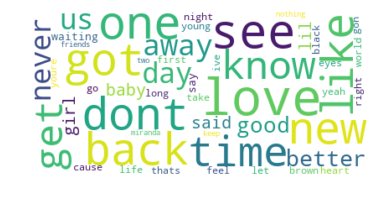

In [214]:
# word cloud for hits
song_words = ['feat','verse',]
counts_dict = {}
for lyrics in hits[(hits['year'] == 2009)]['lyrics']:
    words = nltk.word_tokenize(lyrics)
    for word in words:
        word = re.sub(r'[^\w\s]','',word)
        if word not in (nltk.corpus.stopwords.words()+song_words) and not word.isnumeric():
            if word in counts_dict:
                counts_dict[word] = counts_dict[word]+1
            else:
                counts_dict[word] = 1


# only keep very frequent words
top_words = {key:val for key, val in counts_dict.items() if val > 25 and key != ""}

# generate wordcloud
wordcloud=WordCloud(max_font_size=60,
                    background_color='white',
                    stopwords=['the','to','of','and','is','as','in','verse','love']
                   ).generate_from_frequencies(top_words)

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig("figures/wordcloudhits.pdf")


In [ ]:
# word cloud for duds
counts_dict = {}
for lyrics in duds[(duds['year'] == 2009)]['lyrics']:
    words = nltk.word_tokenize(lyrics)
    for word in words:
        word = re.sub(r'[^\w\s]','',word)
        if word not in (nltk.corpus.stopwords.words()+song_words) and not word.isnumeric():
            if word in counts_dict:
                counts_dict[word] = counts_dict[word]+1
            else:
                counts_dict[word] = 1

# only keep very frequent words
top_words = {key:val for key, val in counts_dict.items() if val > 30 and key != ""}

# generate wordcloud
wordcloud=WordCloud(max_font_size=60,
                    background_color='white',
                    stopwords=['the','to','of','and','is','as','in','verse','feat']
                   ).generate_from_frequencies(top_words)

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig("figures/wordcloudduds.pdf")
